# Práctico 1: Recomendación de Artistas

En este práctico trabajaremos con el conjuto de datos de [LastFM](https://grouplens.org/datasets/hetrec-2011/) para el desarrollo de un sistema de recomendación que, dado el nombre de un artista musical, devuelve una lista de artistas "similares".

Para el práctico utilizaremos el conjunto de datos de LastFM que consiguieron del [notebook de instalación](./instalacion.ipynb). Se recomienda leer el [Readme](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-lastfm-readme.txt) de los datos para saber más sobre que información contiene cada archivo.

La idea del práctico es hacer un análisis muy sencillo del conjunto de datos y desarrollar un sistema de recomendación basado en filtrado colaborativo (usando Surpr!se), a partir de los datos existentes.

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from surprise import Dataset, Reader, KNNWithMeans, BaselineOnly, SVD, SlopeOne, CoClustering, NormalPredictor
from surprise.accuracy import rmse
from surprise.model_selection import cross_validate, train_test_split
from scipy.sparse import csr_matrix

In [50]:
artist_data = pd.read_csv("./data/lastfm/artists.dat", sep="\t")
artist_data.head()

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [51]:
user_artist_plays = pd.read_csv("./data/lastfm/user_artists.dat", sep="\t")
user_artist_plays.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [52]:
user_tagged_artist = pd.read_csv("./data/lastfm/user_taggedartists.dat", sep="\t")
user_tagged_artist.head()

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009


In [53]:
#tags = pd.read_csv("./data/lastfm/tags.dat", sep="\t")
#tags.head()

In [54]:
tags = pd.read_csv("./data/lastfm/tags.dat", sep="\t", encoding='Windows-1252')
tags.head()

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal


## Ejercicio 1 - Análisis Exploratorio de Datos

En esta primera parte deberán hacer un análisis exploratorio de los datos, aprovechando toda la información brindada por el conjunto. A partir de eso podrán tener mayor idea de qué tipo de datos estarán enfrentando (describe o hist).

Algunas preguntas para responder:
- ¿Cuáles son los artistas que fueron más escuchados?
- ¿Cómo es la distribución de cantidad de listens por user?
- ¿Es posible ver el género más escuchado?

#### Los artistas más escuchados:

Presentamos un top ten de los artistas junto a la cdad de escuchas

In [55]:
toptenartistplay = user_artist_plays.groupby('artistID')['weight'].agg('sum').sort_values(ascending=False).head(10)
toptenartistplay = pd.DataFrame(toptenartistplay)
toptenartistplay.index.names = ['id']
toptenartistplay.merge(artist_data, on='id')[['name','weight']]

,name,weight
0,Britney Spears,2393140
1,Depeche Mode,1301308
2,Lady Gaga,1291387
3,Christina Aguilera,1058405
4,Paramore,963449
5,Madonna,921198
6,Rihanna,905423
7,Shakira,688529
8,The Beatles,662116
9,Katy Perry,532545


#### Distribución de cantidad de listens por user:

Como hay 1892 usuarios, no es factible graficar uno por uno.
Para tener una idea de la distribución de la cdad de escuchas primeramente mostramos los outliers de esta cdad, si bien son muchos (8,5%) decidimos continuar trabajando sin ellos.
Presentamos un gráfico de barras que indica cuantas cdades de escuchas (weight) caen en cada rango, lo que permite interpretarse como cdad de usuarios que han escuchado una cdad entre min y max (rango).
Por último detallamos algunos estadísticos.

In [56]:
userplay = user_artist_plays.groupby('userID')['weight'].agg('sum')
userplay = pd.DataFrame(userplay)
userplay['userID']=userplay.index
userplay.shape

(1892, 2)

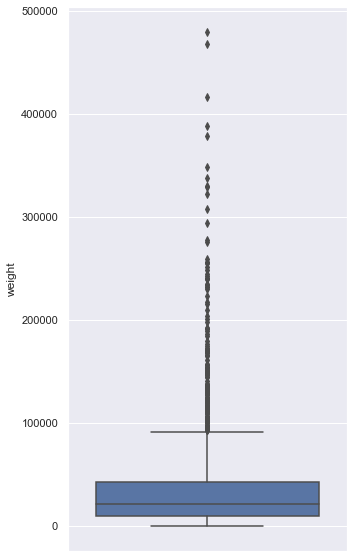

In [57]:
plt.figure(figsize=(5,10))
sns.set() 
g = sns.boxplot(data=userplay, y='weight')

In [58]:
Q1 = userplay.weight.quantile(1/4)
Q3 = userplay.weight.quantile(3/4)
IQR = Q3 - Q1

is_outlier = (userplay.weight <= Q1 - 1.5*IQR) | (userplay.weight >= Q3 + 1.5*IQR)
print('Bajo el criterio de 1.5 * IQR encontramos', sum(is_outlier), 'outliers para weight')

Bajo el criterio de 1.5 * IQR encontramos 161 outliers para weight


In [59]:
userplaysinoutliers=userplay[(userplay.weight > Q1 - 1.5*IQR) & (userplay.weight < Q3 + 1.5*IQR)]
userplaysinoutliers.shape

(1731, 2)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]), <a list of 19 Text xticklabel objects>)

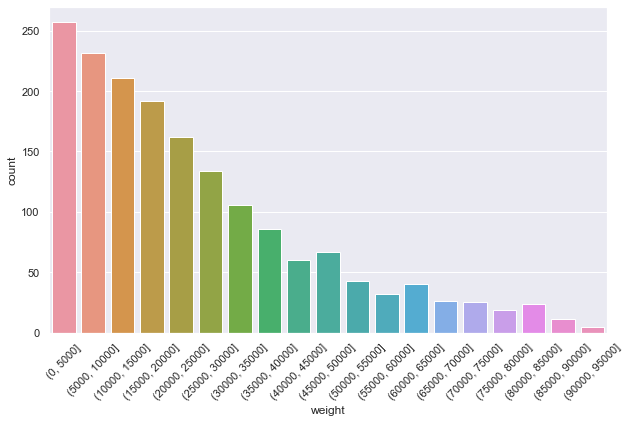

In [60]:
def to_categorical(column, bin_size=5000, min_cut=0, max_cut=100000):
    if min_cut is None:
        min_cut = int(round(column.min())) - 1
    value_max = int(np.ceil(column.max()))
    max_cut = min(max_cut, value_max)
    intervals = [(x, x+bin_size) for x in range(min_cut, max_cut, bin_size)]
    if max_cut != value_max:
        intervals.append((max_cut, value_max))
    return pd.cut(column, pd.IntervalIndex.from_tuples(intervals))
plt.figure(figsize=(10,6))
sns.countplot(to_categorical(userplaysinoutliers.weight))
plt.xticks(rotation=45)

In [61]:
userplaysinoutliers['weight'].describe()

count     1731.000000
mean     24786.816869
std      20725.086331
min          3.000000
25%       8681.000000
50%      19451.000000
75%      35193.500000
max      91678.000000
Name: weight, dtype: float64

#### El genero más escuchado:

Presentamos el género (etiqueta) más escuchado. Como un artista puede tener asignado más de un genero, incluso por el mismo usuario, la cantidad de play de cada artista se está sumando más de una vez, por lo que podría no ser info de gran interés.
Notar que el artista más escuchado es Britney y el género es pop (coincide), pudiendo deducirse que tal vez las etiquetas fueron bien colocadas en los artistas.

In [62]:
artistgenero = user_tagged_artist.merge(user_artist_plays, on='artistID')
artistgeneromay = artistgenero.groupby('tagID')['weight'].agg('sum').sort_values(ascending=False).head(1)
artistgeneromay = pd.DataFrame(artistgeneromay)
artistgeneromay.merge(tags, on='tagID')[['tagValue','weight']]

,tagValue,weight
0,pop,1043039517


## Ejercicio 2 - Matriz de Usuario-Contenido

En este ejercicio, a partir del conjunto de datos, deberán generar una matriz de usuario-contenido. Tengan en cuenta que los ratings, en este caso, son implícitos, puesto que se dan a partir de la cantidad de veces que un usuario escuchó a cierto artista.

In [63]:
matrix = pd.pivot_table(user_artist_plays, values='weight', index='userID', columns='artistID').fillna(0)
matrix

artistID,1,2,3,4,5,6,7,8,9,10,...,18736,18737,18738,18739,18740,18741,18742,18743,18744,18745
userID,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2097,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
from scipy.sparse import csr_matrix

def create_X(df):
    M = df['userID'].nunique()
    N = df['artistID'].nunique()

    user_mapper = dict(zip(np.unique(df["userID"]), list(range(M))))
    artist_mapper = dict(zip(np.unique(df["artistID"]), list(range(N))))
    
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userID"])))
    artist_inv_mapper = dict(zip(list(range(N)), np.unique(df["artistID"])))
    
    user_index = [user_mapper[i] for i in df['userID']]
    item_index = [artist_mapper[i] for i in df['artistID']]

    X = csr_matrix((df["weight"], (user_index,item_index)), shape=(M,N))
    
    return X, user_mapper, artist_mapper, user_inv_mapper, artist_inv_mapper

X, user_mapper, artist_mapper, user_inv_mapper, artist_inv_mapper = create_X(user_artist_plays)
print(X)

  (0, 45)	13883
  (0, 46)	11690
  (0, 47)	11351
  (0, 48)	10300
  (0, 49)	8983
  (0, 50)	6152
  (0, 51)	5955
  (0, 52)	4616
  (0, 53)	4337
  (0, 54)	4147
  (0, 55)	3923
  (0, 56)	3782
  (0, 57)	3735
  (0, 58)	3644
  (0, 59)	3579
  (0, 60)	3312
  (0, 61)	3301
  (0, 62)	2927
  (0, 63)	2720
  (0, 64)	2686
  (0, 65)	2654
  (0, 66)	2619
  (0, 67)	2584
  (0, 68)	2547
  (0, 69)	2397
  :	:
  (1891, 8127)	284
  (1891, 8129)	650
  (1891, 8130)	456
  (1891, 8131)	1068
  (1891, 8133)	626
  (1891, 8134)	613
  (1891, 8139)	655
  (1891, 8151)	640
  (1891, 8324)	232
  (1891, 8328)	429
  (1891, 8330)	607
  (1891, 8332)	724
  (1891, 9548)	793
  (1891, 9752)	228
  (1891, 10573)	705
  (1891, 13134)	278
  (1891, 13136)	346
  (1891, 13404)	535
  (1891, 15609)	443
  (1891, 17614)	758
  (1891, 17615)	337
  (1891, 17616)	297
  (1891, 17617)	281
  (1891, 17618)	280
  (1891, 17619)	263


In [65]:
n_ratings_per_artist = X.getnnz(axis=0)
sum_ratings_per_artist = X.sum(axis=0)
mean_rating_per_artist = sum_ratings_per_artist/n_ratings_per_artist
X_mean_artist = np.tile(mean_rating_per_artist, (X.shape[0],1))
X_mean_artist.shape
X_norm = X - csr_matrix(X_mean_artist)

## Ejercicio 3 - Entrenamiento del algoritmo de recomendación

Utilizando las herramientas brindadas por Surpr!se, entrenen varios modelos de sistemas de recomendación basados en filtrado colaborativo a partir de su matriz de usuario-contenido. Recuerden tener en cuenta lo aprendido en la diplomatura a la hora de evaluar y validar el modelo.

Si necesitan inspiración, les recomiendo revisar [este notebook con información de como entrenar un sistema de recomendación con Surpr!se](https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Building%20Recommender%20System%20with%20Surprise.ipynb).

In [66]:
reader = Reader(rating_scale=(user_artist_plays.weight.min(), user_artist_plays.weight.max()))
user_artist_plays_r = Dataset.load_from_df(user_artist_plays[["userID", "artistID", "weight"]], reader)

In [67]:
ratings_train, ratings_test = train_test_split(user_artist_plays_r, test_size=0.2)

#### NormalPredictor

In [68]:
model = NormalPredictor().fit(ratings_train)
predictions1 = model.test(ratings_test)
print("RMSE on test: {:.4f}".format(rmse(predictions1, verbose=False)))

RMSE on test: 4429.8571


In [69]:
def get_Iu(uid):
    try:
        return len(ratings_train.ur[ratings_train.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
def get_Ui(iid):
    try: 
        return len(ratings_train.ir[ratings_train.to_inner_iid(iid)])
    except ValueError:
        return 0 
df = pd.DataFrame(predictions1, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions = df.sort_values(by='err')[:5]
worst_predictions = df.sort_values(by='err')[-5:]

In [70]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
16323,712,204,1.0,1.0,{'was_impossible': False},30,40,0.0
10142,1868,17272,1.0,1.0,{'was_impossible': False},33,0,0.0
10810,1867,17264,1.0,1.0,{'was_impossible': False},35,0,0.0
7047,115,2898,1.0,1.0,{'was_impossible': False},42,2,0.0
17952,995,790,1.0,1.0,{'was_impossible': False},29,52,0.0


In [71]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
4595,442,187,112009.0,1.000000,{'was_impossible': False},37,83,112008.000000
2508,903,503,146411.0,5045.655305,{'was_impossible': False},37,52,141365.344695
16839,946,687,144559.0,1.000000,{'was_impossible': False},39,53,144558.000000
7523,514,292,176133.0,2585.462994,{'was_impossible': False},37,319,173547.537006
2733,1146,378,203165.0,1.000000,{'was_impossible': False},38,174,203164.000000


#### BaselineOnly

In [72]:
model = BaselineOnly().fit(ratings_train)
predictions2 = model.test(ratings_test)
print("RMSE on test: {:.4f}".format(rmse(predictions2, verbose=False)))

Estimating biases using als...
RMSE on test: 3382.5096


In [73]:
def get_Iu(uid):
    try:
        return len(ratings_train.ur[ratings_train.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
def get_Ui(iid):
    try: 
        return len(ratings_train.ir[ratings_train.to_inner_iid(iid)])
    except ValueError:
        return 0 
df = pd.DataFrame(predictions2, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions = df.sort_values(by='err')[:5]
worst_predictions = df.sort_values(by='err')[-5:]

In [74]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
12754,1310,525,1.0,1.0,{'was_impossible': False},35,116,0.0
6437,2051,2629,1.0,1.0,{'was_impossible': False},42,16,0.0
6390,229,1596,1.0,1.0,{'was_impossible': False},34,15,0.0
10987,229,301,1.0,1.0,{'was_impossible': False},34,121,0.0
6266,499,3110,1.0,1.0,{'was_impossible': False},41,28,0.0


In [75]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
4595,442,187,112009.0,712.002510,{'was_impossible': False},37,83,111296.997490
16839,946,687,144559.0,1150.111622,{'was_impossible': False},39,53,143408.888378
2508,903,503,146411.0,2000.292732,{'was_impossible': False},37,52,144410.707268
7523,514,292,176133.0,4398.138296,{'was_impossible': False},37,319,171734.861704
2733,1146,378,203165.0,2749.288166,{'was_impossible': False},38,174,200415.711834


#### KNNWithMeans

In [76]:
model = KNNWithMeans(k=5).fit(ratings_train)
predictions3 = model.test(ratings_test)
print("RMSE on test: {:.4f}".format(rmse(predictions3, verbose=False)))

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE on test: 4118.8224


In [77]:
def get_Iu(uid):
    try:
        return len(ratings_train.ur[ratings_train.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
def get_Ui(iid):
    try: 
        return len(ratings_train.ir[ratings_train.to_inner_iid(iid)])
    except ValueError:
        return 0 
df = pd.DataFrame(predictions3, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions = df.sort_values(by='err')[:5]
worst_predictions = df.sort_values(by='err')[-5:]

In [78]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
8801,1014,545,1.0,1.0,"{'actual_k': 5, 'was_impossible': False}",17,29,0.0
6437,2051,2629,1.0,1.0,"{'actual_k': 5, 'was_impossible': False}",42,16,0.0
7259,2051,9324,1.0,1.0,"{'actual_k': 1, 'was_impossible': False}",42,1,0.0
16323,712,204,1.0,1.0,"{'actual_k': 5, 'was_impossible': False}",30,40,0.0
9401,1262,793,1.0,1.0,"{'actual_k': 5, 'was_impossible': False}",16,39,0.0


In [79]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
2508,903,503,146411.0,2975.038467,"{'actual_k': 5, 'was_impossible': False}",37,52,143435.961533
16839,946,687,144559.0,546.605070,"{'actual_k': 5, 'was_impossible': False}",39,53,144012.394930
10950,147,498,328.0,153117.292441,"{'actual_k': 5, 'was_impossible': False}",39,317,152789.292441
7523,514,292,176133.0,3470.500260,"{'actual_k': 5, 'was_impossible': False}",37,319,172662.499740
2733,1146,378,203165.0,2834.158897,"{'actual_k': 5, 'was_impossible': False}",38,174,200330.841103


#### SVD

In [80]:
model = SVD().fit(ratings_train)
predictions4 = model.test(ratings_test)
print("RMSE on test: {:.4f}".format(rmse(predictions4, verbose=False)))

RMSE on test: 351973.3582


In [81]:
def get_Iu(uid):
    try:
        return len(ratings_train.ur[ratings_train.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
def get_Ui(iid):
    try: 
        return len(ratings_train.ir[ratings_train.to_inner_iid(iid)])
    except ValueError:
        return 0 
df = pd.DataFrame(predictions4, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions = df.sort_values(by='err')[:5]
worst_predictions = df.sort_values(by='err')[-5:]

In [82]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
2733,1146,378,203165.0,352698,{'was_impossible': False},38,174,149533.0
7523,514,292,176133.0,352698,{'was_impossible': False},37,319,176565.0
2508,903,503,146411.0,352698,{'was_impossible': False},37,52,206287.0
16839,946,687,144559.0,352698,{'was_impossible': False},39,53,208139.0
4595,442,187,112009.0,352698,{'was_impossible': False},37,83,240689.0


In [83]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
7381,344,1167,1.0,352698,{'was_impossible': False},29,20,352697.0
14840,1408,989,1.0,352698,{'was_impossible': False},40,14,352697.0
18065,2051,6407,1.0,352698,{'was_impossible': False},42,1,352697.0
11797,1867,4827,1.0,352698,{'was_impossible': False},35,2,352697.0
4804,1432,3768,1.0,352698,{'was_impossible': False},8,19,352697.0


#### SlopeOne

In [84]:
model = SlopeOne().fit(ratings_train)
predictions5 = model.test(ratings_test)
print("RMSE on test: {:.4f}".format(rmse(predictions5, verbose=False)))

RMSE on test: 3418.6233


In [85]:
def get_Iu(uid):
    try:
        return len(ratings_train.ur[ratings_train.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
def get_Ui(iid):
    try: 
        return len(ratings_train.ir[ratings_train.to_inner_iid(iid)])
    except ValueError:
        return 0 
df = pd.DataFrame(predictions5, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions = df.sort_values(by='err')[:5]
worst_predictions = df.sort_values(by='err')[-5:]

In [86]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
9179,712,3676,1.0,1.0,{'was_impossible': False},30,14,0.0
11797,1867,4827,1.0,1.0,{'was_impossible': False},35,2,0.0
8581,1588,733,1.0,1.0,{'was_impossible': False},42,51,0.0
15851,229,1604,1.0,1.0,{'was_impossible': False},34,1,0.0
7736,1859,859,1.0,1.0,{'was_impossible': False},30,54,0.0


In [87]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
4595,442,187,112009.0,732.734210,{'was_impossible': False},37,83,111276.265790
16839,946,687,144559.0,1405.686651,{'was_impossible': False},39,53,143153.313349
2508,903,503,146411.0,2702.838017,{'was_impossible': False},37,52,143708.161983
7523,514,292,176133.0,5187.755006,{'was_impossible': False},37,319,170945.244994
2733,1146,378,203165.0,3163.591027,{'was_impossible': False},38,174,200001.408973


#### CoClustering

In [88]:
model = CoClustering().fit(ratings_train)
predictions6 = model.test(ratings_test)
print("RMSE on test: {:.4f}".format(rmse(predictions6, verbose=False)))

RMSE on test: 3456.3263


In [89]:
def get_Iu(uid):
    try:
        return len(ratings_train.ur[ratings_train.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
def get_Ui(iid):
    try: 
        return len(ratings_train.ir[ratings_train.to_inner_iid(iid)])
    except ValueError:
        return 0 
df = pd.DataFrame(predictions6, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions = df.sort_values(by='err')[:5]
worst_predictions = df.sort_values(by='err')[-5:]

In [90]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
17952,995,790,1.0,1.0,{'was_impossible': False},29,52,0.0
8389,1262,545,1.0,1.0,{'was_impossible': False},16,29,0.0
2285,1665,3758,1.0,1.0,{'was_impossible': False},30,5,0.0
6963,1262,12407,1.0,1.0,{'was_impossible': False},16,1,0.0
1947,1552,1475,1.0,1.0,{'was_impossible': False},10,20,0.0


In [91]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
4595,442,187,112009.0,800.500053,{'was_impossible': False},37,83,111208.499947
16839,946,687,144559.0,1010.523141,{'was_impossible': False},39,53,143548.476859
2508,903,503,146411.0,2406.551891,{'was_impossible': False},37,52,144004.448109
7523,514,292,176133.0,5345.862138,{'was_impossible': False},37,319,170787.137862
2733,1146,378,203165.0,3316.857259,{'was_impossible': False},38,174,199848.142741


#### Resumen

In [92]:
print("NormalPredictor - RMSE: {:.4f}".format(rmse(predictions1, verbose=False)))
print("BaselineOnly - RMSE: {:.4f}".format(rmse(predictions2, verbose=False)))
print("KNNWithMeans - RMSE: {:.4f}".format(rmse(predictions3, verbose=False)))
print("SVD - RMSE: {:.4f}".format(rmse(predictions4, verbose=False)))
print("SlopeOne - RMSE: {:.4f}".format(rmse(predictions5, verbose=False)))
print("CoClustering - RMSE: {:.4f}".format(rmse(predictions6, verbose=False)))

NormalPredictor - RMSE: 4429.8571
BaselineOnly - RMSE: 3382.5096
KNNWithMeans - RMSE: 4118.8224
SVD - RMSE: 351973.3582
SlopeOne - RMSE: 3418.6233
CoClustering - RMSE: 3456.3263


NormalPredictor, BaselineOnly, KNNWithMeans y SlopeOne tiene una raiz de error cuadrático medio similar, el valor más bajo corresponde a BaselineOnly (tras varias ejecuciones modificando los datos de train y test siempre este es el mejor). Por el contrario SVD tiene un valor muy alto.

En cuanto a las presentaciones de mejor/peor predicción, las mismas se pueden leer del siguiente modo:
"En este caso el artista iid fue escuchado por ui usuarios; el usuario uid escuchó rui veces a este artista sin embargo el modelo predice est"

## Ejercicio 4 - Sistema de recomendación

A partir del mejor modelo de recomendación que hayan sugerido en el caso anterior, y utilizando los datos del archivo `artist.dat`, armar un sistema de recomendación sencillo que, dado un nombre de un artista, devuelva el top 10 de artistas más similares.

La idea es que el sistema tome el nombre de un artista y devuelva el nombre de otros artistas (no simplemente tomar y devolver IDs). Se recomienda [revisar este notebook para inspiración (ver el paso número 5)](https://github.com/topspinj/pydata-workshop/blob/master/tutorial.ipynb).

In [93]:
model = BaselineOnly().fit(ratings_train)
predictions2 = model.test(ratings_test)

Estimating biases using als...


In [94]:
from sklearn.neighbors import NearestNeighbors

def find_similar_artist(artist_id, X, artist_mapper, artist_inv_mapper, k, metric='cosine'):
    X = X.T
    neighbour_ids = []
    
    artist_ind = artist_mapper[artist_id]
    artist_vec = X[artist_ind]
    if isinstance(artist_vec, (np.ndarray)):
        artist_vec = artist_vec.reshape(1,-1)
    # use k+1 since kNN output includes the artistId of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(artist_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(artist_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [95]:
def buscar_id_artist(artist_analisis):
    return artist_data[artist_data.name == artist_analisis]['id']

In [96]:
artist_analisis = 'Oz Alchemist'
for i in buscar_id_artist(artist_analisis):
    artist_id = i
similar_artist = find_similar_artist(artist_id, X_norm, artist_mapper, artist_inv_mapper, k=10)
df_similar_artist = pd.DataFrame(similar_artist, columns=['id'])
df_similar_artist.merge(artist_data, on='id')[['name']]

,name
0,Aya RL
1,Ciccone Youth
2,Cubanate
3,Apollo 440
4,The Young Gods
5,Diamanda Galás
6,Oz Alchemist
7,Coptic Rain
8,Die Krupps


#### Resumen

Modificar el valor de la variable artist_analisis, indicando el nombre de la película que se desea analizar.